#Mounting Google Drive

In [ ]:
# Mounting Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Extracting a Zip File

In [ ]:
# Extracting a ZIP file in Google Colab
import zipfile

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/Datasets/processed_dataset.zip'

# Extracting the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

#Organizing Images and Labels

In [ ]:
# Separating images and labels into respective folders in Google Colab
import os
import shutil

# Path to the train, test, and val folders
train_folder = '/content/data/content/train'
test_folder = '/content/data/content/test'
val_folder = '/content/data/content/val'

# Function to separate images and labels into their respective folders
def separate_images_labels(folder_path):
    """
    Separates images and labels into their respective folders.

    Args:
        folder_path (str): Path to the folder containing images and labels.
    """
    # Create 'images' and 'labels' folders
    images_folder = os.path.join(folder_path, 'images')
    labels_folder = os.path.join(folder_path, 'labels')
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)

    # Move files to the respective folders
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith('.jpg') or file_name.lower().endswith('.jpeg'):
            shutil.move(file_path, os.path.join(images_folder, file_name))
        elif file_name.lower().endswith('.xml'):
            shutil.move(file_path, os.path.join(labels_folder, file_name))

# Separate images and labels within the train folder
separate_images_labels(train_folder)

# Separate images and labels within the test folder
separate_images_labels(test_folder)

# Separate images and labels within the val folder
separate_images_labels(val_folder)

print("Separation completed successfully.")


Separation completed successfully.


#Data Preprocessing and Generation

In [ ]:
# Data Preprocessing and Data Generator in TensorFlow for image classification
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def parse_xml_label(label_path):
    """
    Parses an XML label file and extracts label information.

    Args:
        label_path (str): Path to the XML label file.

    Returns:
        list: A list of tuples containing label information (name, (xmin, ymin, xmax, ymax)).
    """
    # Parse the XML label
    tree = ET.parse(label_path)
    root = tree.getroot()

    # Extract label information
    label_info = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        label_info.append((name, (xmin, ymin, xmax, ymax)))

    return label_info

def preprocess_image(image, target_size):
    """
    Preprocesses an image by resizing and normalizing it.

    Args:
        image (numpy.ndarray): The input image.
        target_size (tuple): The target size for resizing the image.

    Returns:
        numpy.ndarray: The preprocessed image.
    """
    # Resize the image
    resized_image = cv2.resize(image, target_size)
    preprocessed_image = resized_image.astype(np.float32) / 255.0

    return preprocessed_image

def preprocess_data(image_path, label_path, target_size, num_classes, class_to_index):
    """
    Preprocesses an image and its corresponding label.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the XML label file.
        target_size (tuple): The target size for resizing the image.
        num_classes (int): The number of classes.
        class_to_index (dict): A dictionary mapping class names to their respective indices.

    Returns:
        tuple: A tuple containing the preprocessed image and its corresponding label tensor.
    """
    image = cv2.imread(image_path)
    label_info = parse_xml_label(label_path)

    preprocessed_image = preprocess_image(image, target_size)

    label_tensor = np.zeros((num_classes,), dtype=np.float32)
    for name, bbox in label_info:
        if name in class_to_index:
            label_tensor[class_to_index[name]] = 1.0

    return preprocessed_image, label_tensor


def data_generator(image_dir, label_dir, target_size, num_classes, class_to_index, batch_size=32):
    """
    Generates batches of preprocessed images and their corresponding label tensors.

    Args:
        image_dir (str): Path to the directory containing the images.
        label_dir (str): Path to the directory containing the XML label files.
        target_size (tuple): The target size for resizing the images.
        num_classes (int): The number of classes.
        class_to_index (dict): A dictionary mapping class names to their respective indices.
        batch_size (int, optional): The batch size. Defaults to 32.

    Yields:
        tuple: A tuple containing the batch of preprocessed images and their corresponding label tensors.
    """
    image_filenames = [filename for filename in os.listdir(image_dir) if filename.endswith('.jpg')]
    num_samples = len(image_filenames)
    steps_per_epoch = num_samples // batch_size

    while True:
        np.random.shuffle(image_filenames)

        for i in range(steps_per_epoch):
            batch_start = i * batch_size
            batch_end = (i + 1) * batch_size
            batch_filenames = image_filenames[batch_start:batch_end]

            batch_images = []
            batch_labels = []

            for filename in batch_filenames:
                image_path = os.path.join(image_dir, filename)
                label_path = os.path.join(label_dir, filename.replace('.jpg', '.xml'))

                image, label = preprocess_data(image_path, label_path, target_size, num_classes, class_to_index)

                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)


# Define the paths to the image and label directories
image_dir = '/content/data/content/train/images'
label_dir = '/content/data/content/train/labels'

# Define the target input size for the model
target_size = (224, 224)

# Define the number of classes and class-to-index mapping
num_classes = 2
class_to_index = {'focused': 0, 'not focused': 1}

# Create the data generator
batch_size = 32
train_data_generator = data_generator(image_dir, label_dir, target_size, num_classes, class_to_index, batch_size)

# Define the paths to the validation image and label directories
val_image_dir = '/content/data/content/val/images'
val_label_dir = '/content/data/content/val/labels'

# Create the validation generator
validation_generator = data_generator(val_image_dir, val_label_dir , target_size, num_classes, class_to_index, batch_size)

#Model Training and Evaluation

In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    """
    Custom callback class to monitor the training progress and stop training when a certain condition is met.

    This class extends the `tf.keras.callbacks.Callback` class and overrides the `on_epoch_end` method.

    Attributes:
        None

    Methods:
        on_epoch_end(epoch, logs): Function called at the end of each epoch.

    Usage:
        callback = myCallback()
        model.fit(x_train, y_train, callbacks=[callback])
    """

    def on_epoch_end(self, epoch, logs={}):
        """
        Function called at the end of each epoch.

        Args:
            epoch (int): The current epoch number.
            logs (dict): Dictionary containing the training metrics.

        Returns:
            None
        """
        if logs.get('accuracy') > 0.80:
            print("\nReached 90% accuracy, so cancelling training!")
            self.model.stop_training = True


In [ ]:
import tensorflow as tf

# Define the CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# Compile the model with appropriate loss, metrics, and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Create an instance of the custom callback
callbacks = myCallback()

# Train the model
epochs = 35
steps_per_epoch = len(os.listdir(image_dir)) // batch_size
history = model.fit(train_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=8,
          callbacks=[callbacks])


Epoch 1/35
39/39 [==============================] - 331s 8s/step - loss: 0.7869 - accuracy: 0.5337 - precision: 0.4982 - recall: 0.3822 - auc: 0.5566 - val_loss: 0.6936 - val_accuracy: 0.2578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3696
Epoch 2/35
39/39 [==============================] - 313s 8s/step - loss: 0.6793 - accuracy: 0.5505 - precision: 0.5503 - recall: 0.2905 - auc: 0.5803 - val_loss: 0.6510 - val_accuracy: 0.7305 - val_precision: 0.8067 - val_recall: 0.4979 - val_auc: 0.7231
Epoch 3/35
39/39 [==============================] - 313s 8s/step - loss: 0.6608 - accuracy: 0.6058 - precision: 0.5879 - recall: 0.4092 - auc: 0.6391 - val_loss: 0.6065 - val_accuracy: 0.7383 - val_precision: 0.7610 - val_recall: 0.6420 - val_auc: 0.7255
Epoch 4/35
39/39 [==============================] - 291s 8s/step - loss: 0.6493 - accuracy: 0.5729 - precision: 0.5726 - recall: 0.5067 - auc: 0.6550 - val_loss: 0.6203 - val_accuracy: 0.7305 - val_precision: 0.7975 - val_recal

In [ ]:
model.summary()

NameError: ignored

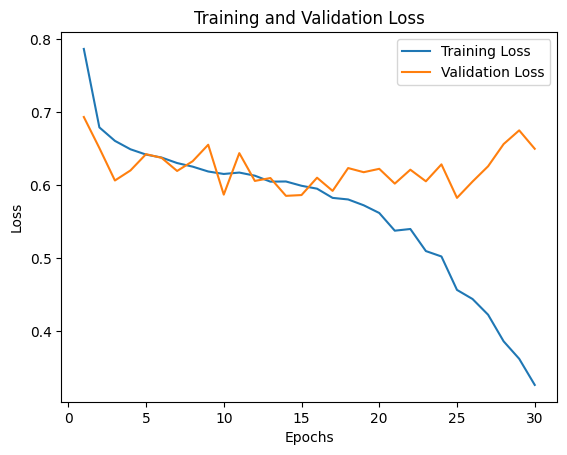

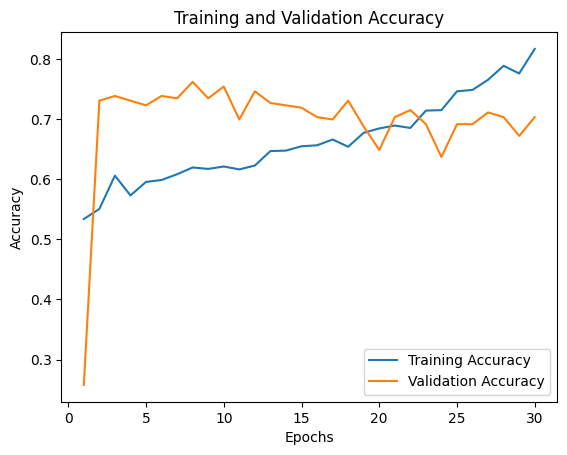

In [ ]:
import matplotlib.pyplot as plt
# Retrieve loss and accuracy values from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the loss graph
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the accuracy graph
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Model Prediction

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Upload image file
uploaded = files.upload()

# Iterate over uploaded files
for fn in uploaded.keys():
    # Load and preprocess the image
    path = fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    # Predict the class probabilities
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Print the predicted class probabilities
    print(classes[0])

    # Determine the predicted class and print the result
    if classes[0][0] > 0.85:
        print(fn + " Fokus")
        print("Confident level: ", classes[0][0])
    else:
        print(fn + " Tidak Fokus")
        print("Confident level: ", classes[0][1])

#Model Saving

In [ ]:
#import time

# # Generate a unique filename based on the current timestamp
#saved_model_path = "./maman{}.h5".format(int(time.time()))

# # Save the model to the specified path
#model.save(saved_model_path)

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/FokusIn_Capstone_Project/Models/'

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


export_path = /content/drive/MyDrive/FokusIn_Capstone_Project/Models/1
total 243
drwx------ 2 root root   4096 Jun 14 10:31 assets
-rw------- 1 root root     56 Jun 14 10:31 fingerprint.pb
-rw------- 1 root root  22498 Jun 14 10:31 keras_metadata.pb
-rw------- 1 root root 216886 Jun 14 10:31 saved_model.pb
drwx------ 2 root root   4096 Jun 14 10:31 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all

2023-06-14 10:31:44.446731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/pred